# Analytics & Applications WS23/24 Project

The following notebook contains the applied steps of the CRISP-DM model on the
project excercise from "Analytics and Applications" by Prof. Ketter in the WS23/24 of University Cologne.

The following steps will be done in the specified order:
1. Data Preparation
2. Modeling 
3. Evaluation

## Imports & Dependencies

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import json

## Import Data

In [106]:
# ToDo: use path object
df = pd.read_csv("data/charging_sessions.csv")
df_weather = pd.read_csv("data/weather_modified.csv")

## Data Exploration and Preparation

### Basic Data Exploration

In [107]:
print(df.head())

   Unnamed: 0                        id             connectionTime  \
0           0  5e23b149f9af8b5fe4b973cf  2020-01-02 13:08:54+00:00   
1           1  5e23b149f9af8b5fe4b973d0  2020-01-02 13:36:50+00:00   
2           2  5e23b149f9af8b5fe4b973d1  2020-01-02 13:56:35+00:00   
3           3  5e23b149f9af8b5fe4b973d2  2020-01-02 13:59:58+00:00   
4           4  5e23b149f9af8b5fe4b973d3  2020-01-02 14:00:01+00:00   

              disconnectTime           doneChargingTime  kWhDelivered  \
0  2020-01-02 19:11:15+00:00  2020-01-02 17:31:35+00:00        25.016   
1  2020-01-02 22:38:21+00:00  2020-01-02 20:18:05+00:00        33.097   
2  2020-01-03 00:39:22+00:00  2020-01-02 16:35:06+00:00         6.521   
3  2020-01-02 16:38:39+00:00  2020-01-02 15:18:45+00:00         2.355   
4  2020-01-02 22:08:40+00:00  2020-01-02 18:17:30+00:00        13.375   

                                sessionID  siteID  spaceID    stationID  \
0  1_1_179_810_2020-01-02 13:08:53.870034       1  AG-3F30  1-1-1

In [108]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66450 entries, 0 to 66449
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        66450 non-null  int64  
 1   id                66450 non-null  object 
 2   connectionTime    66450 non-null  object 
 3   disconnectTime    66450 non-null  object 
 4   doneChargingTime  62362 non-null  object 
 5   kWhDelivered      66450 non-null  float64
 6   sessionID         66450 non-null  object 
 7   siteID            66450 non-null  int64  
 8   spaceID           66450 non-null  object 
 9   stationID         66450 non-null  object 
 10  timezone          66450 non-null  object 
 11  userID            49187 non-null  float64
 12  userInputs        49187 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 6.6+ MB
None


In [109]:
print(df.describe())

         Unnamed: 0  kWhDelivered        siteID        userID
count  66450.000000  66450.000000  66450.000000  49187.000000
mean    4726.102062     11.787916      1.472656   1800.494582
std     3568.025394     10.314789      0.499256   2617.548614
min        0.000000      0.501000      1.000000      1.000000
25%     1845.000000      5.097000      1.000000    431.000000
50%     3960.000000      9.140000      1.000000    818.000000
75%     7027.000000     14.183000      2.000000   1805.000000
max    15291.000000    108.797242      2.000000  19923.000000


### Set Data Types

In [110]:
# Set Datatypes
df['connectionTime'] = pd.to_datetime(df['connectionTime'])
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'])
df['doneChargingTime'] = pd.to_datetime(df['doneChargingTime'])

df['sessionID'] = df['sessionID'].astype(str)
df['siteID'] = df['siteID'].astype(str)
df['spaceID'] = df['spaceID'].astype(str)
df['stationID'] = df['stationID'].astype(str)
df['userID'] = df['userID'].astype(str)

In [111]:
print("Earliest Entry in the Dataset: " + str(df['connectionTime'].min()))
print("Latest Entry in the Dataset: " + str(df['connectionTime'].max()))

Earliest Entry in the Dataset: 2018-04-25 11:08:04+00:00
Latest Entry in the Dataset: 2021-09-14 05:43:39+00:00


In [112]:
# Rename first column, contains an index
df = df.rename(columns={df.columns[0]: 'Index'})
df = df.set_index('Index')

In [113]:
# Session ID is a composite value of stationID and connectionTime, and therefor redundant
# Timezone contains only one value, and can therefor be considered meta-data
df = df.drop(['sessionID', 'timezone'], axis=1)

In [114]:
df['NoChargingTime'] = df['disconnectTime'] - df['doneChargingTime']
df['NoChargingTimeMinutes'] = (df['NoChargingTime']).dt.total_seconds() / 60.0  # Convert seconds to minutes

df['ChargingTime'] = df['doneChargingTime'] - df['connectionTime']
df['ChargingTimeMinutes'] = (df['ChargingTime']).dt.total_seconds() / 60.0  # Convert seconds to minutes

df['kWhPerMinute'] = df['kWhDelivered'] / df['ChargingTimeMinutes']

# Create a new column 'month' to store the month information
df['month'] = df['connectionTime'].dt.month

In [115]:
# Initialize a Dataframe for Exploration
df_exploration = df.set_index('connectionTime')

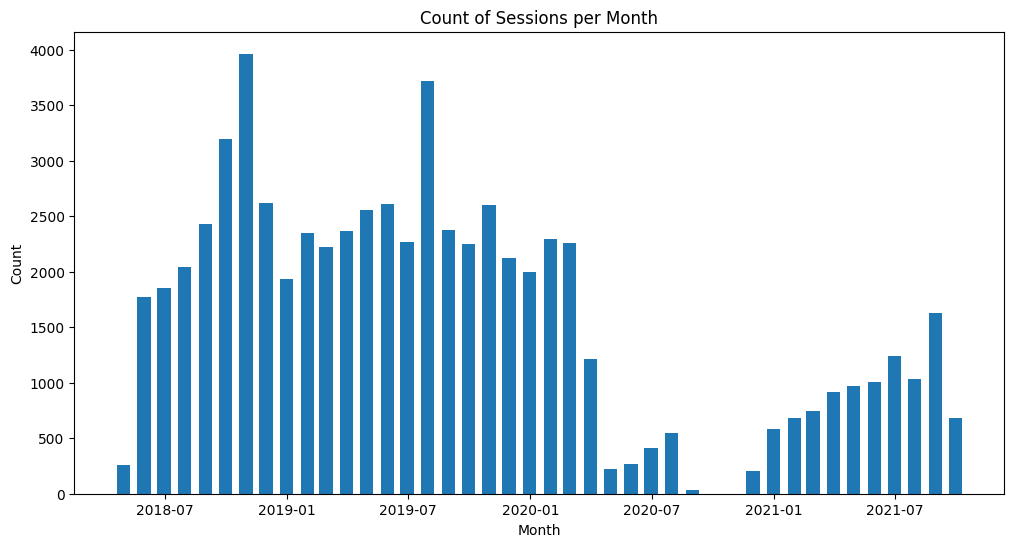

In [116]:
monthly_counts = df_exploration.resample('M').count()
# Plotting
plt.figure(figsize=(12, 6))
plt.bar(monthly_counts.index, monthly_counts['id'], width=20, align='center')
plt.title('Count of Sessions per Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

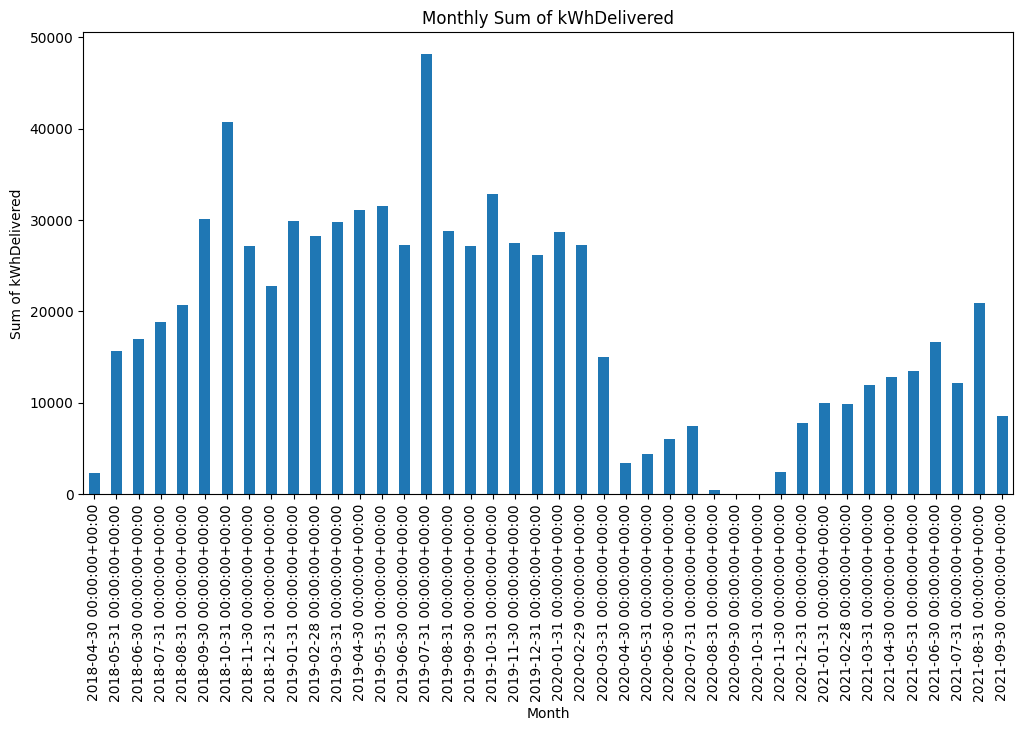

In [117]:
exploration_monthly = df_exploration['kWhDelivered'].resample('M').sum()

# Plot the monthly sum
plt.figure(figsize=(12, 6))
exploration_monthly.plot(kind='bar')
plt.title('Monthly Sum of kWhDelivered')
plt.xlabel('Month')
plt.ylabel('Sum of kWhDelivered')
plt.show()

In [118]:
# TImeframe of missing data
mask = (df['connectionTime'] > '2020-08-04') & (df['connectionTime'] <= '2020-11-18')
missingData = df.loc[mask]
missingData

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,siteID,spaceID,stationID,userID,userInputs,NoChargingTime,NoChargingTimeMinutes,ChargingTime,ChargingTimeMinutes,kWhPerMinute,month
Index,,,,,,,,,,,,,,,,


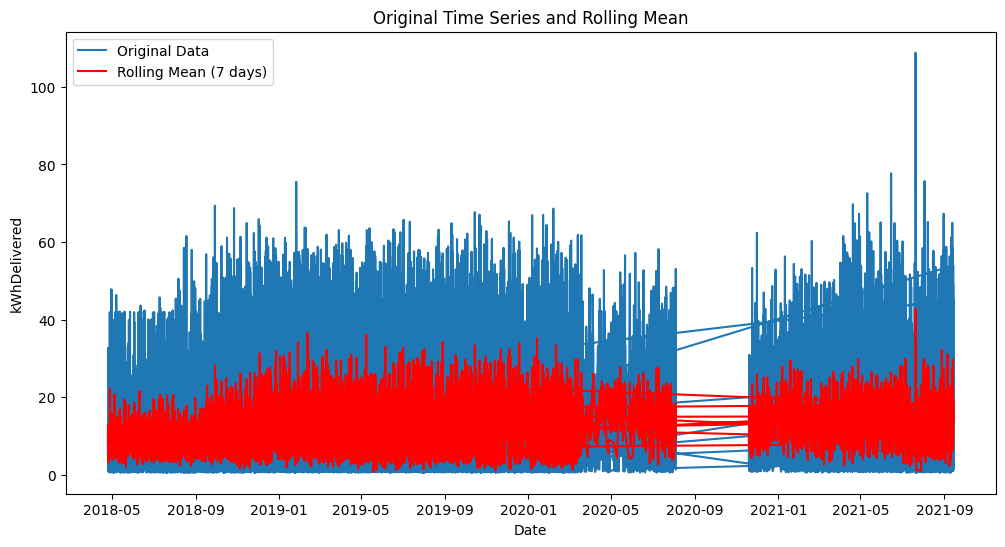

In [119]:
# Calculate rolling mean for a specified window (e.g., 7 days)
rolling_mean = exploration['kWhDelivered'].rolling(window=7).mean()

# Plot the original time series and the rolling mean
plt.figure(figsize=(12, 6))
plt.plot(exploration['kWhDelivered'], label='Original Data')
plt.plot(rolling_mean, label='Rolling Mean (7 days)', color='red')
plt.title('Original Time Series and Rolling Mean')
plt.xlabel('Date')
plt.ylabel('kWhDelivered')
plt.legend()
plt.show()

### Handle Missing and Erronous Data

### Calculate the Time a Car used the Station without Charging

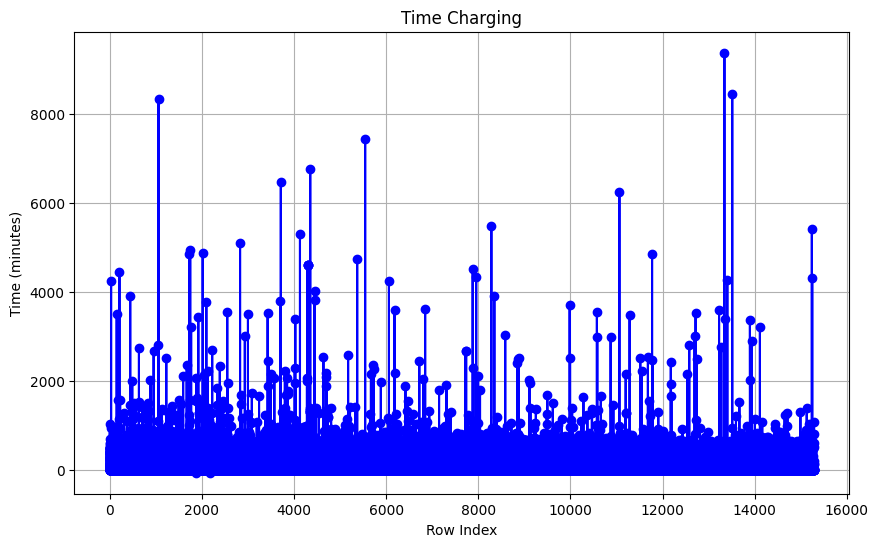

In [120]:
# Plot the time differences
plt.figure(figsize=(10, 6))
plt.plot(df['NoChargingTimeMinutes'], marker='o', linestyle='-', color='b')
plt.title('Time Charging')
plt.xlabel('Row Index')
plt.ylabel('Time (minutes)')
plt.grid(True)
plt.show()

### Calculate the Charging Time

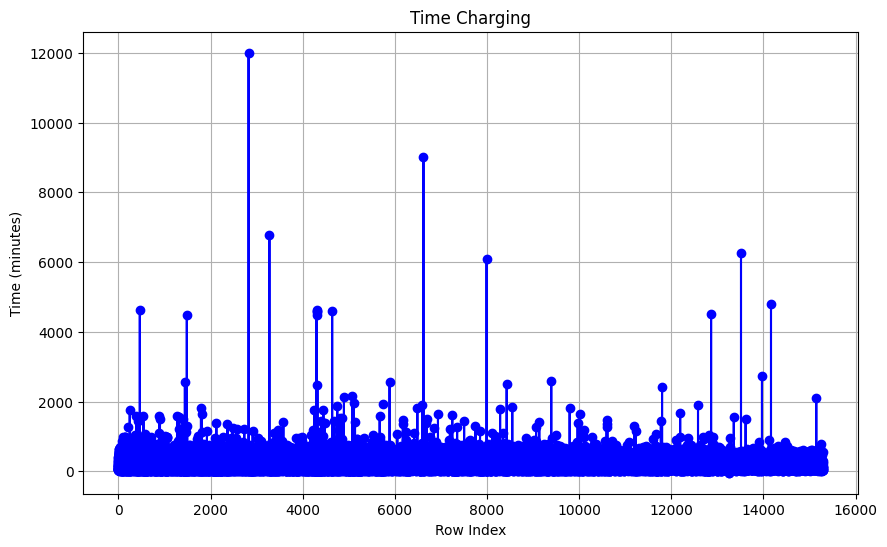

In [121]:
# Plot the time differences
plt.figure(figsize=(10, 6))
plt.plot(df['ChargingTimeMinutes'], marker='o', linestyle='-', color='b')
plt.title('Time Charging')
plt.xlabel('Row Index')
plt.ylabel('Time (minutes)')
plt.grid(True)
plt.show()

### Calculate Outliers with the IQR

In [122]:
# Calculate the interquartile range (IQR) for time differences
Q1 = df['ChargingTimeMinutes'].quantile(0.25)
Q3 = df['ChargingTimeMinutes'].quantile(0.75)
IQR = Q3 - Q1

# Define a threshold for outliers based on IQR (e.g., 1.5 times IQR)
threshold = 1.5

# Identify outliers based on IQR
outliers = df[(df['ChargingTimeMinutes'] > (Q3 + threshold * IQR))]

# Display or further analyze the outliers
print("Outliers based on IQR:")
print(outliers)

Outliers based on IQR:
                             id            connectionTime  \
Index                                                       
6      5e23b149f9af8b5fe4b973d5 2020-01-02 14:09:14+00:00   
29     5e23b149f9af8b5fe4b973ec 2020-01-02 16:28:23+00:00   
81     5e28f766f9af8b70ebc91c98 2020-01-06 12:32:26+00:00   
83     5e28f766f9af8b70ebc91c9a 2020-01-06 12:48:56+00:00   
164    5e2a48e8f9af8b75aed8e931 2020-01-07 13:47:26+00:00   
...                         ...                       ...   
10041  5d574ad2f9af8b4c10c03628 2019-07-31 13:19:31+00:00   
10051  5d574ad2f9af8b4c10c03632 2019-07-31 13:49:27+00:00   
10058  5d574ad2f9af8b4c10c03639 2019-07-31 14:04:17+00:00   
10059  5d574ad2f9af8b4c10c0363a 2019-07-31 14:05:20+00:00   
10080  5d574ad2f9af8b4c10c0364f 2019-07-31 14:48:11+00:00   

                 disconnectTime          doneChargingTime  kWhDelivered  \
Index                                                                     
6     2020-01-03 01:57:58+00:00 2

### Split the Stations in to a new Column Station with have the entry 1 or 2

In [123]:
# Create a new column 'is_1_or_2' based on whether 'stationID' starts with '1' or '2'
df['station'] = df['stationID'].astype(str).apply(lambda x: '1' if x.startswith('1') else '2' if x.startswith('2') else None)

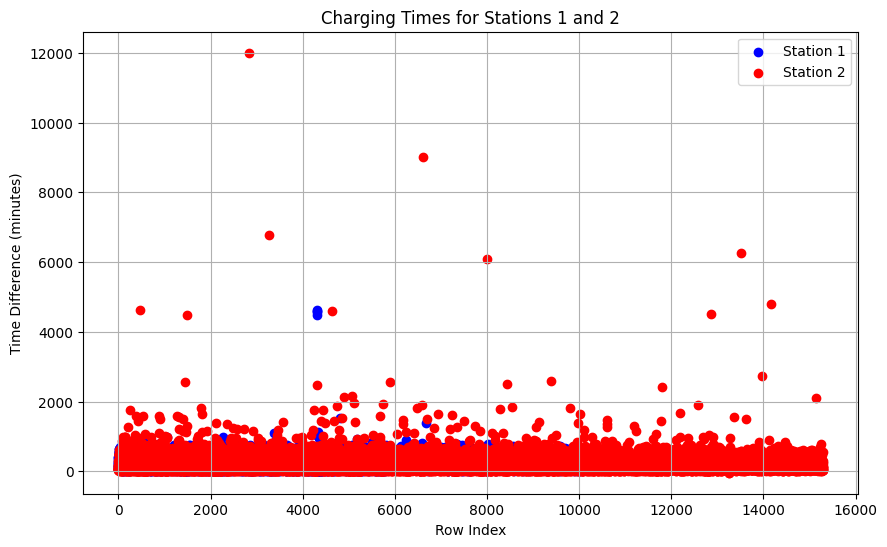

In [124]:
# Plot the time differences for station 1 in blue and station 2 in red
plt.figure(figsize=(10, 6))

# Plot time differences for station 1 (blue)
plt.scatter(df[df['station'] == '1'].index, df[df['station'] == '1']['ChargingTimeMinutes'], color='blue', label='Station 1')

# Plot time differences for station 2 (red)
plt.scatter(df[df['station'] == '2'].index, df[df['station'] == '2']['ChargingTimeMinutes'], color='red', label='Station 2')

plt.title('Charging Times for Stations 1 and 2')
plt.xlabel('Row Index')
plt.ylabel('Time Difference (minutes)')
plt.legend()
plt.grid(True)
plt.show()

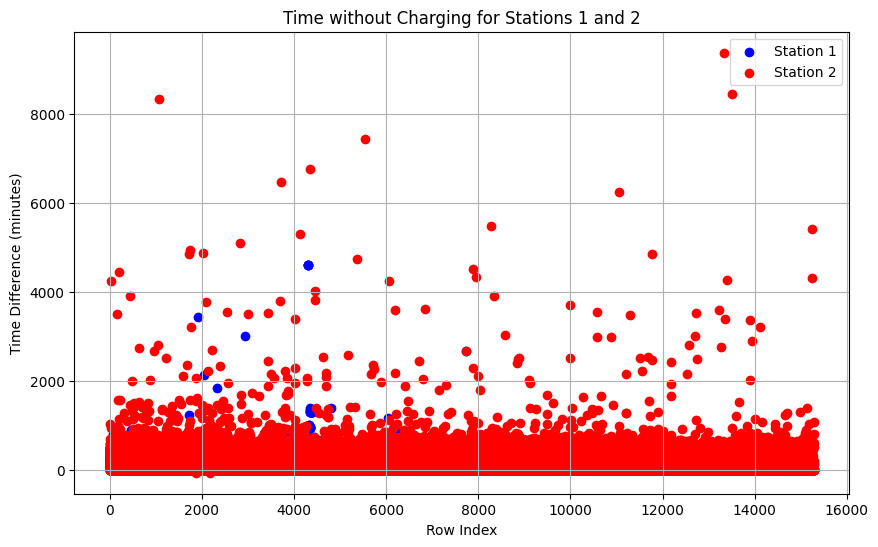

In [125]:
# Plot the time differences for station 1 in blue and station 2 in red
plt.figure(figsize=(10, 6))

# Plot time differences for station 1 (blue)
plt.scatter(df[df['station'] == '1'].index, df[df['station'] == '1']['NoChargingTimeMinutes'], color='blue', label='Station 1')

# Plot time differences for station 2 (red)
plt.scatter(df[df['station'] == '2'].index, df[df['station'] == '2']['NoChargingTimeMinutes'], color='red', label='Station 2')

plt.title('Time without Charging for Stations 1 and 2')
plt.xlabel('Row Index')
plt.ylabel('Time Difference (minutes)')
plt.legend()
plt.grid(True)
plt.show()

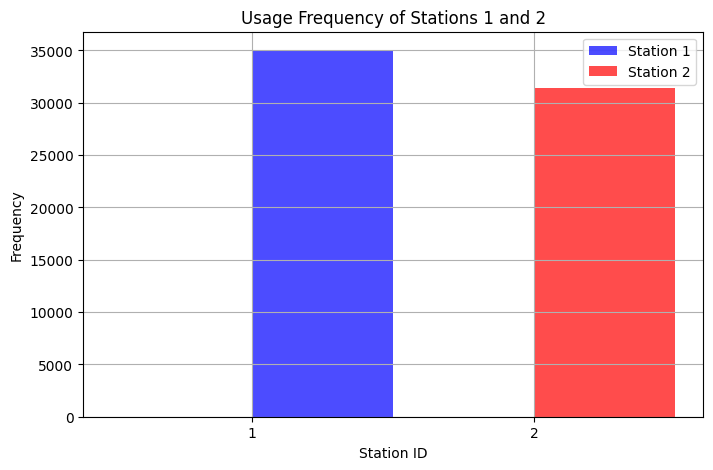

In [126]:
# Plot a histogram for the usage frequency of each station
plt.figure(figsize=(8, 5))

# Plot histogram for station 1
plt.hist(df[df['station'] == '1']['station'], bins=2, color='blue', alpha=0.7, label='Station 1')

# Plot histogram for station 2
plt.hist(df[df['station'] == '2']['station'], bins=2, color='red', alpha=0.7, label='Station 2')

plt.title('Usage Frequency of Stations 1 and 2')
plt.xlabel('Station ID')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

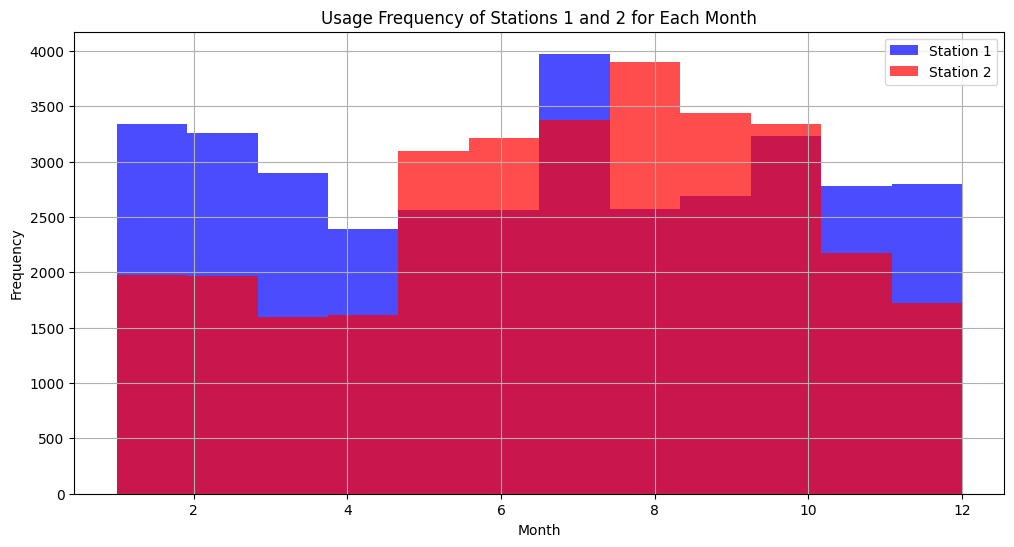

In [127]:
# Plot the usage frequency of stations for every month
plt.figure(figsize=(12, 6))

# Plot histogram for station 1
plt.hist(df[df['station'] == '1']['month'], bins=12, color='blue', alpha=0.7, label='Station 1')

# Plot histogram for station 2
plt.hist(df[df['station'] == '2']['month'], bins=12, color='red', alpha=0.7, label='Station 2')

plt.title('Usage Frequency of Stations 1 and 2 for Each Month')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [128]:
df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'])

# Group by day and calculate the mean temperature for each day
df_weather_mean_per_day = df_weather.groupby(df_weather['timestamp'].dt.date)['temperature'].mean().reset_index()

# Display or save the resulting DataFrame
print(df_weather_mean_per_day)

       timestamp  temperature
0     2018-01-01    14.000000
1     2018-01-02    16.041667
2     2018-01-03    17.916667
3     2018-01-04    16.791667
4     2018-01-05    17.375000
...          ...          ...
1092  2020-12-28    10.000000
1093  2020-12-29     8.416667
1094  2020-12-30    11.240000
1095  2020-12-31    11.360000
1096  2021-01-01    12.500000

[1097 rows x 2 columns]


         key_0                        id            connectionTime  \
0            2  5e23b149f9af8b5fe4b973cf 2020-01-02 13:08:54+00:00   
1            2  5e23b149f9af8b5fe4b973cf 2020-01-02 13:08:54+00:00   
2            2  5e23b149f9af8b5fe4b973cf 2020-01-02 13:08:54+00:00   
3            2  5e23b149f9af8b5fe4b973cf 2020-01-02 13:08:54+00:00   
4            2  5e23b149f9af8b5fe4b973cf 2020-01-02 13:08:54+00:00   
...        ...                       ...                       ...   
2365126     26  5d50b34ff9af8b34f280b3ec 2019-07-26 23:43:11+00:00   
2365127     26  5d50b34ff9af8b34f280b3ec 2019-07-26 23:43:11+00:00   
2365128     26  5d50b34ff9af8b34f280b3ec 2019-07-26 23:43:11+00:00   
2365129     26  5d50b34ff9af8b34f280b3ec 2019-07-26 23:43:11+00:00   
2365130     26  5d50b34ff9af8b34f280b3ec 2019-07-26 23:43:11+00:00   

                   disconnectTime          doneChargingTime  kWhDelivered  \
0       2020-01-02 19:11:15+00:00 2020-01-02 17:31:35+00:00        25.016   
1    

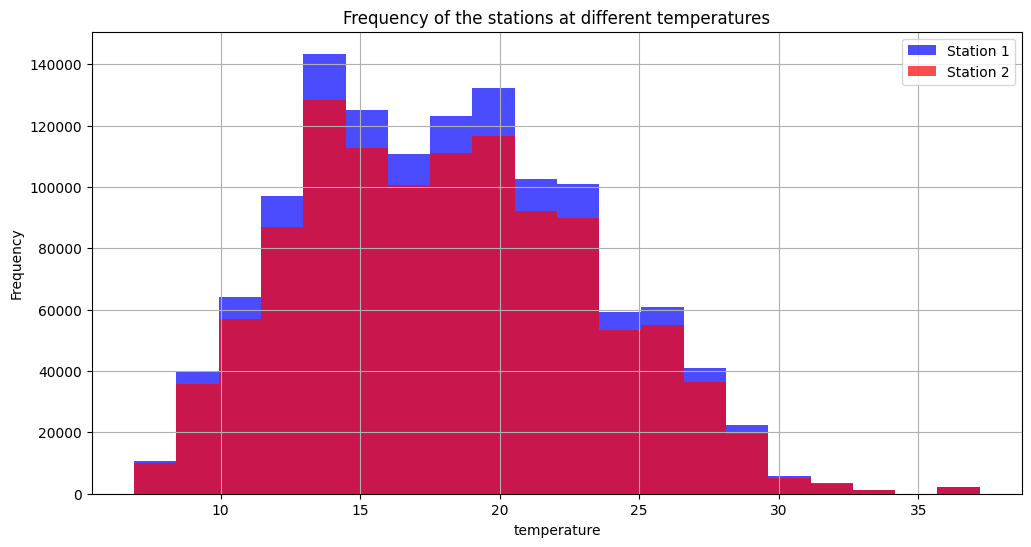

In [129]:
df_weather_mean_per_day['timestamp'] = pd.to_datetime(df_weather_mean_per_day['timestamp'])

# Merge the two dataframes based on the day of the month
merged_df = pd.merge(df, df_weather_mean_per_day, left_on=df['connectionTime'].dt.day, right_on=df_weather_mean_per_day['timestamp'].dt.day, how='inner')
print(merged_df[merged_df['station'] == '1'])
# Create a line plot of average temperature against the day of the month
plt.figure(figsize=(12, 6))

plt.hist(merged_df[merged_df['station'] == '1']['temperature'], bins=20, color='blue', alpha=0.7, label='Station 1')

plt.hist(merged_df[merged_df['station'] == '2']['temperature'], bins=20, color='red', alpha=0.7, label='Station 2')

plt.title('Frequency of the stations at different temperatures')
plt.xlabel('temperature')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [130]:
# TODO Annabelle:
# Schauen wie die durchschnittswerte sind --> Vielleicht kommen verteilungen daher
# Anschauen, wie häufig eine Station am Tag im Schnitt genutzt wird

# TODO Freddy:
# - Expand User Inputs column > drop user ID from user Inputs column, since its redundant
# Erroneous Data:
#   NAT for Charging Done Time (largerThan = df[df['doneChargingTime'].isnull()])
#   Too long charging Times + Volumes (Check Realistic Charging Rate)
#   Gap in Fall 2020

### Flatten the Json-Object UserInput

In [131]:
df['userInputs'] = df['userInputs'].str.replace("'", '"')
df['userInputs'] = df['userInputs'].str.replace('"[', "'[")
df['userInputs'] = df['userInputs'].str.replace(']"', "]'")
df['userInputs'] = df['userInputs'].str.replace("True", "true")
df['userInputs'] = df['userInputs'].str.replace("False", "false")

# Old Version
# for i in range(len(df['userInputs'])):
#     if not pd.isna(df['userInputs'].iloc[i]):
#        df.at[i, 'userInputs'] = json.loads(df['userInputs'].iloc[i])

# Refactored Version
df['userInputs'] = df['userInputs'].apply(lambda x: json.loads(x) if pd.notna(x) else x)